# MOM-SIS 0.1$^\circ$ Diagnostics

This notebook calculates and retains key diagnostics from our mom01v5 simulations. The following experiments are included:

| Experiment Name | Size | Description |
|-----------------|------|-----------------|
|GFDL50 | 2.2T | Original simulation with 50 vertical levels. Ran from Levitus for about 60 years, but data output only saved from about year 40.|
|KDS75 | 17 T|Branched from GFDL50 at year 45 (re-zeroed), but with Kial Stewart's 75 level scheme. Has now run for 103 years. Years 90-100 have 5-daily output.|
| KDS75_wind | 1.1T| Short (5-year) Antarctic wind perturbation case, branched from KDS75 at year 40.|
| KDS75_PI | 5.1T | Paul Spence's Poleward Intensification wind experiment. Branched from KDS75 at year 70, will run until year 100 with 5-daily output for the last decade|
| KDS75_UP | 0.8T| Paul Spence's Increased winds case. Branched from KDS75 at year 70, will run until year 100 with 5-daily output for the last decade. (In Progress) |


In [1]:
%matplotlib inline

import os
from glob import glob
import numpy as np

from netCDF4 import Dataset

import dask
import xarray as xr

from dask.dot import dot_graph

from mpl_toolkits.basemap import Basemap, shiftgrid
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook

/mnt/miniconda3/envs/cosima/lib/python3.6/site-packages/xarray/core/formatting.py:16: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime


In [4]:
DataDir = '/g/data3/hh5/tmp/cosima/mom01v5'

expts = ['GFDL50','KDS75','KDS75_UP','KDS75_PI','KDS75_wind']

In [6]:
from dask.distributed import Client, LocalCluster

client = Client('tcp://10.0.0.32:8786')
client

<Client: scheduler='tcp://10.0.0.32:8786' processes=24 cores=24>

## Wind Stress fields
The following code block shows the zonal- and time-averaged wind stress forcing for each experiment.

In [5]:
expt = 'KDS75_wind'
ExpDir = os.path.join(DataDir, expt)
FileList = sorted(glob(os.path.join(ExpDir, 'output*/ocean_month.nc')))

dsx = xr.open_dataset(FileList[0])

/mnt/miniconda3/envs/cosima/lib/python3.6/site-packages/xarray/conventions.py:389: RuntimeWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)
/mnt/miniconda3/envs/cosima/lib/python3.6/site-packages/xarray/conventions.py:408: RuntimeWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  calendar=self.calendar)


In [6]:
dsx

/mnt/miniconda3/envs/cosima/lib/python3.6/site-packages/xarray/conventions.py:408: RuntimeWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  calendar=self.calendar)


<xarray.Dataset>
Dimensions:                   (nv: 2, time: 3, xt_ocean: 3600, xu_ocean: 3600, yt_ocean: 2700, yu_ocean: 2700)
Coordinates:
  * xt_ocean                  (xt_ocean) float64 -279.9 -279.8 -279.7 -279.6 ...
  * yt_ocean                  (yt_ocean) float64 -81.11 -81.07 -81.02 -80.98 ...
  * time                      (time) object   41-01-16 12:00:00 ...
  * nv                        (nv) float64 1.0 2.0
  * xu_ocean                  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 ...
  * yu_ocean                  (yu_ocean) float64 -81.09 -81.05 -81.0 -80.96 ...
    geolon_t                  (yt_ocean, xt_ocean) float64 nan nan nan nan ...
    geolat_t                  (yt_ocean, xt_ocean) float64 nan nan nan nan ...
    geolon_c                  (yu_ocean, xu_ocean) float64 nan nan nan nan ...
    geolat_c                  (yu_ocean, xu_ocean) float64 nan nan nan nan ...
Data variables:
    mld                       (time, yt_ocean, xt_ocean) float64 nan nan nan ...
    

In [7]:
import warnings
warnings.filterwarnings("ignore", message="Unable to decode time axis into full numpy.datetime64 objects")

In [8]:
dsx.tau_x

<xarray.DataArray 'tau_x' (time: 3, yu_ocean: 2700, xu_ocean: 3600)>
[29160000 values with dtype=float64]
Coordinates:
  * time      (time) object   41-01-16 12:00:00   41-02-15 00:00:00 ...
  * xu_ocean  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 -279.5 -279.4 ...
  * yu_ocean  (yu_ocean) float64 -81.09 -81.05 -81.0 -80.96 -80.92 -80.88 ...
    geolon_c  (yu_ocean, xu_ocean) float64 nan nan nan nan nan nan nan nan ...
    geolat_c  (yu_ocean, xu_ocean) float64 nan nan nan nan nan nan nan nan ...
Attributes:
    long_name:      i-directed wind stress forcing u-velocity
    units:          N/m^2
    valid_range:    [-10.  10.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  surface_downward_x_stress

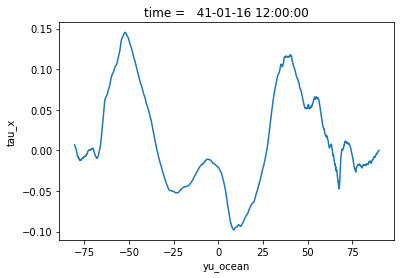

In [9]:
mean_tau_x = dsx.tau_x.isel(time=0).mean('xu_ocean')
mean_tau_x.plot()


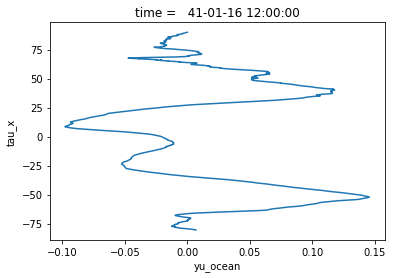

In [10]:
line, = mean_tau_x.plot.line()

xdata = line.get_xdata()
ydata = line.get_ydata()
xlim = plt.xlim()
ylim = plt.ylim()

line.set_xdata(ydata)
line.set_ydata(xdata)
plt.xlim(ylim)
plt.ylim(xlim)

#swap axes labels too!
plt.draw()


## Average Wind Stress

In [11]:
%%time
dsx = xr.open_mfdataset(FileList[-4:])

CPU times: user 344 ms, sys: 8 ms, total: 352 ms
Wall time: 11.9 s


In [12]:
FileList[-4:]

['/g/data3/hh5/tmp/cosima/mom01v5/KDS75_wind/output166/ocean_month.nc',
 '/g/data3/hh5/tmp/cosima/mom01v5/KDS75_wind/output167/ocean_month.nc',
 '/g/data3/hh5/tmp/cosima/mom01v5/KDS75_wind/output168/ocean_month.nc',
 '/g/data3/hh5/tmp/cosima/mom01v5/KDS75_wind/output169/ocean_month.nc']

In [13]:
%%time
dsx.tau_x

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 209 µs


<xarray.DataArray 'tau_x' (time: 12, yu_ocean: 2700, xu_ocean: 3600)>
dask.array<concatenate, shape=(12, 2700, 3600), dtype=float64, chunksize=(3, 2700, 3600)>
Coordinates:
  * xu_ocean  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 -279.5 -279.4 ...
  * yu_ocean  (yu_ocean) float64 -81.09 -81.05 -81.0 -80.96 -80.92 -80.88 ...
    geolon_c  (yu_ocean, xu_ocean) float64 nan nan nan nan nan nan nan nan ...
    geolat_c  (yu_ocean, xu_ocean) float64 nan nan nan nan nan nan nan nan ...
  * time      (time) object   45-01-16 12:00:00   45-02-15 00:00:00 ...
Attributes:
    long_name:      i-directed wind stress forcing u-velocity
    units:          N/m^2
    valid_range:    [-10.  10.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  surface_downward_x_stress

CPU times: user 76 ms, sys: 4 ms, total: 80 ms
Wall time: 2.9 s


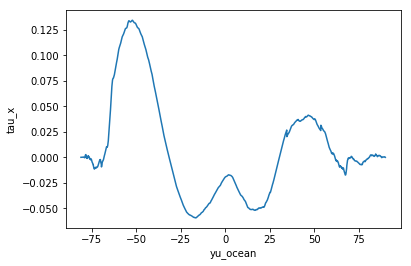

In [14]:
%%time
dsx.tau_x.mean('time').mean('xu_ocean').plot()

In [15]:
%%time
datasets = [xr.open_dataset(fn,
                           ).tau_x for fn in FileList[-4:]]

CPU times: user 104 ms, sys: 4 ms, total: 108 ms
Wall time: 115 ms


In [16]:
%%time
dsx = xr.concat(datasets, dim='time', coords='all')

CPU times: user 4.72 s, sys: 1.11 s, total: 5.83 s
Wall time: 6.11 s


In [17]:
dsx

<xarray.DataArray 'tau_x' (time: 12, yu_ocean: 2700, xu_ocean: 3600)>
array([[[ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan],
        ..., 
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]],

       [[  0.,   0., ...,  nan,  nan],
        [  0.,   0., ...,  nan,  nan],
        ..., 
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]],

       ..., 
       [[  0.,   0., ...,  nan,  nan],
        [  0.,   0., ...,  nan,  nan],
        ..., 
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]],

       [[  0.,   0., ...,  nan,  nan],
        [  0.,   0., ...,  nan,  nan],
        ..., 
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]]])
Coordinates:
  * xu_ocean  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 -279.5 -279.4 ...
  * yu_ocean  (yu_ocean) float64 -81.09 -81.05 -81.0 -80.96 -80.92 -80.88 ...
  * time      (time) object   45-01-16 12:00:00   45-02-15 

In [18]:
FileList[0]

'/g/data3/hh5/tmp/cosima/mom01v5/KDS75_wind/output150/ocean_month.nc'

In [19]:
%%time
datasets = [xr.open_dataset(fn,
                         chunks={'time':1,
                                 'yu_ocean':675, 'xu_ocean':900
                                }).tau_x for fn in FileList[-20:]]

CPU times: user 628 ms, sys: 20 ms, total: 648 ms
Wall time: 732 ms


In [20]:
%%time

dsx = xr.concat(datasets, dim='time', coords='all')

CPU times: user 60 ms, sys: 4 ms, total: 64 ms
Wall time: 64.9 ms


In [21]:
dsx

<xarray.DataArray 'tau_x' (time: 60, yu_ocean: 2700, xu_ocean: 3600)>
dask.array<concatenate, shape=(60, 2700, 3600), dtype=float64, chunksize=(1, 675, 900)>
Coordinates:
  * xu_ocean  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 -279.5 -279.4 ...
  * yu_ocean  (yu_ocean) float64 -81.09 -81.05 -81.0 -80.96 -80.92 -80.88 ...
  * time      (time) object   41-01-16 12:00:00   41-02-15 00:00:00 ...
    geolon_c  (time, yu_ocean, xu_ocean) float64 nan nan nan nan nan nan nan ...
    geolat_c  (time, yu_ocean, xu_ocean) float64 nan nan nan nan nan nan nan ...
Attributes:
    long_name:      i-directed wind stress forcing u-velocity
    units:          N/m^2
    valid_range:    [-10.  10.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  surface_downward_x_stress

In [22]:
dsx.data.dask

In [23]:
len(dsx.data.dask)

1940

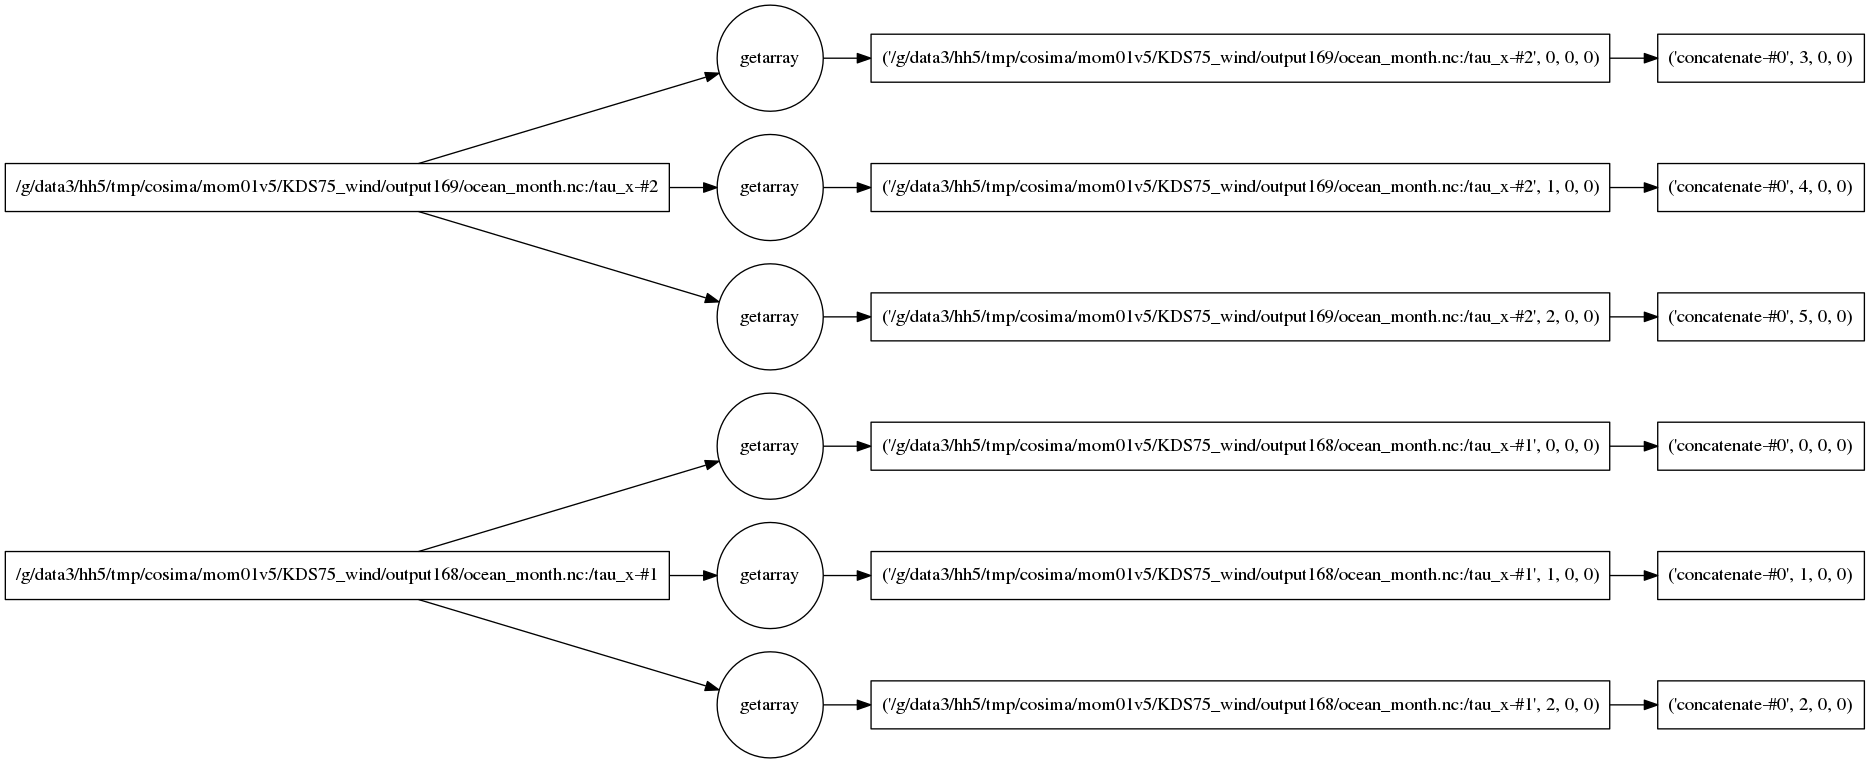

In [33]:
dot_graph(dsx.data.dask, rankdir='LR')

In [24]:
%%time
dsx = dsx.mean('time').mean('xu_ocean')

CPU times: user 68 ms, sys: 0 ns, total: 68 ms
Wall time: 66.9 ms


In [26]:
len(dsx.data.dask)

3240

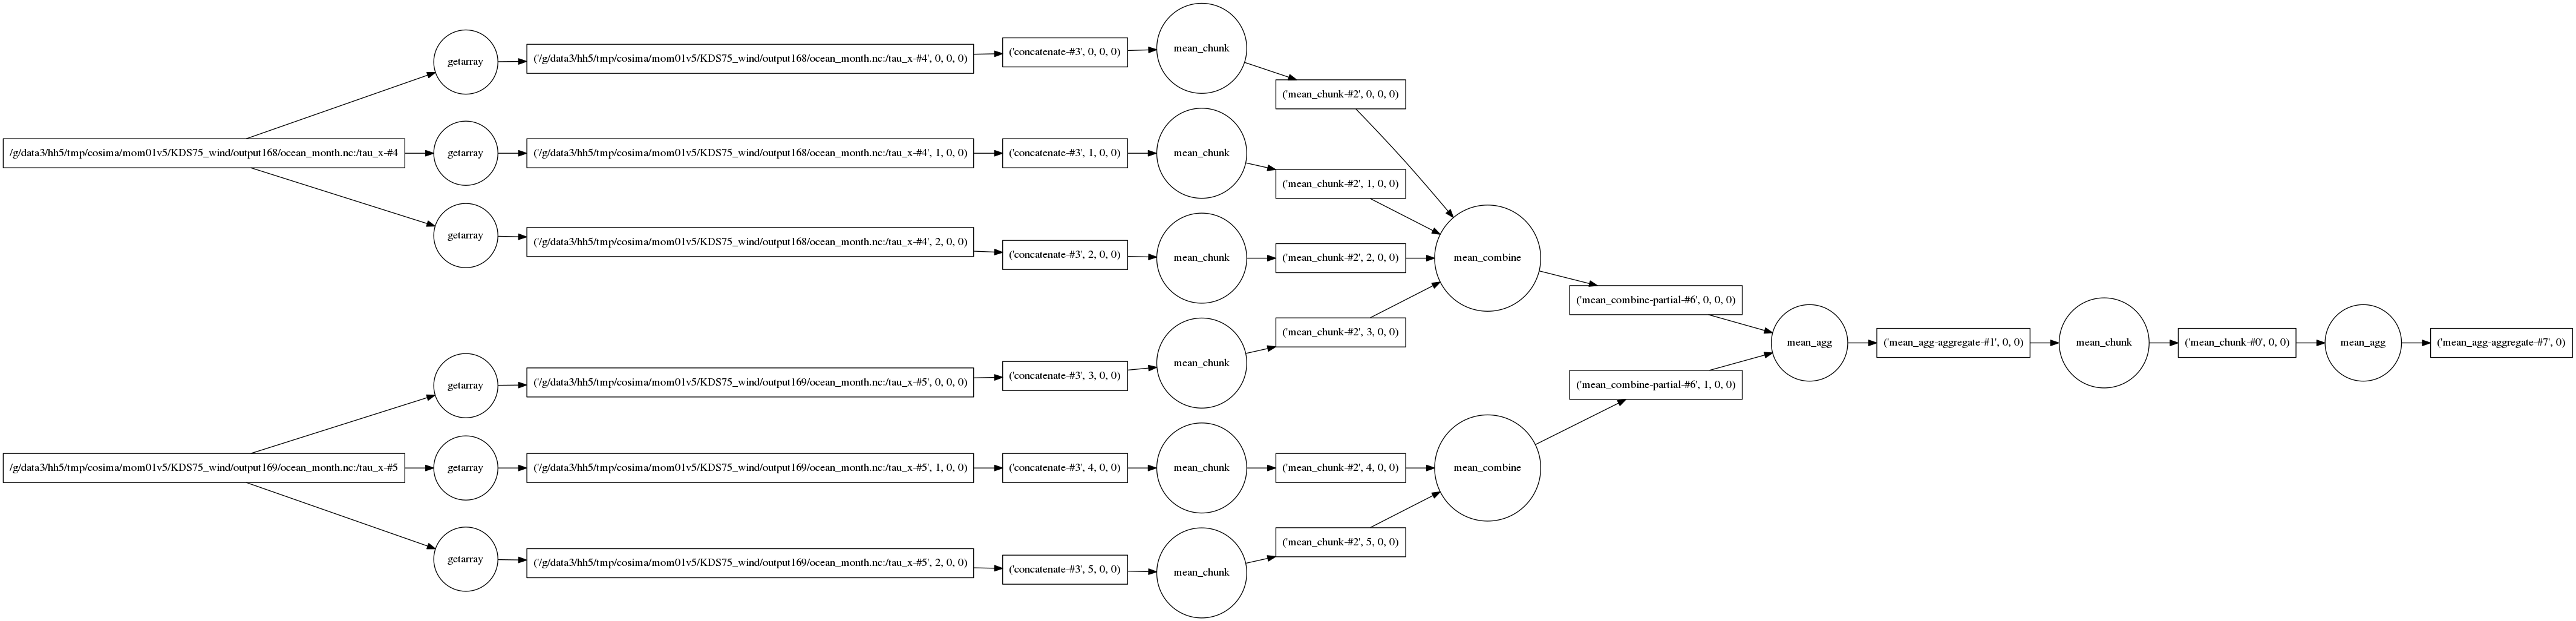

In [39]:
dot_graph(dsx.data.dask, rankdir='LR')

In [25]:
%%time
dsx.load()

CPU times: user 336 ms, sys: 8 ms, total: 344 ms
Wall time: 5.58 s


<xarray.DataArray 'tau_x' (yu_ocean: 2700)>
array([  0.000000e+00,   0.000000e+00,   0.000000e+00, ...,   1.166672e-04,
         8.436115e-05,   0.000000e+00])
Coordinates:
  * yu_ocean  (yu_ocean) float64 -81.09 -81.05 -81.0 -80.96 -80.92 -80.88 ...

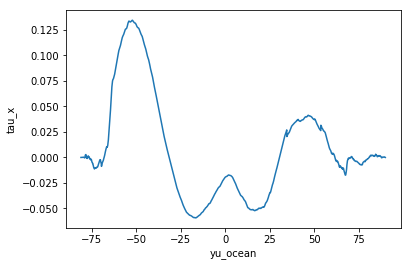

In [26]:
dsx.plot()

In [27]:
%%time
tau_x = {}
for e in tqdm_notebook(expts):
    print(e)
    ExpDir = os.path.join(DataDir, e)
    FileList = sorted(glob(os.path.join(ExpDir, 'output*/ocean_month.nc')))
    
    datasets = [xr.open_dataset(fn, 
                    chunks={'time':1, 'yu_ocean':675, 'xu_ocean':900},
                    ).tau_x for fn in FileList[-20:]]

    dsx = xr.concat(datasets, dim='time', coords='all')
    avg_tau_x = dsx.mean('time').mean('xu_ocean')
    
    avg_tau_x.load()
    tau_x[e] = avg_tau_x

GFDL50
KDS75
KDS75_UP
KDS75_PI
KDS75_wind

CPU times: user 5.96 s, sys: 192 ms, total: 6.15 s
Wall time: 31.4 s


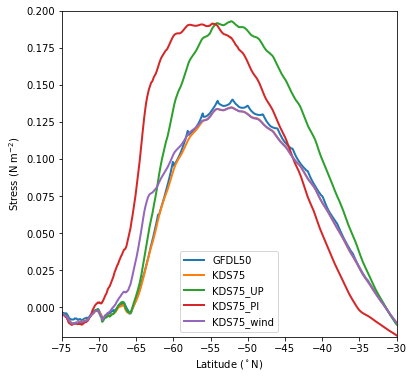

In [28]:
plt.figure(figsize=(6,6))

for e in expts:
    tau_x[e].plot(linewidth=2,label=e)
    
plt.xlim([-75,-30])
plt.ylim([-0.02,0.2])
plt.xlabel('Latitude ($^\circ$N)')
plt.ylabel('Stress (N m$^{-2}$)')
plt.legend(loc=8,fontsize=10)

# Overturning Circulation
Next, let's look at overturning circulation in density space using ty_trans_rho. We will zonally average this diagnostic, without accounting for the tripolar grid, so ignore the Arctic.

In [29]:
expt = 'KDS75'
ExpDir = os.path.join(DataDir, expt)

FileList = sorted(glob(os.path.join(ExpDir, 'output*/ocean.nc')))

In [30]:
datasets = [xr.open_dataset(fn,
                         chunks={'time':1, 
                                 #'potrho':8, 
                                 'grid_yu_ocean':270, 
                                 'grid_xt_ocean': 360})
            for fn in FileList[-20:]]
psi = [ds.ty_trans_rho.sum('grid_xt_ocean')\
         .cumsum('potrho') for ds in datasets]
psi = xr.concat(psi, dim='time')
psi_avg = psi.mean('time')

In [31]:
psi_avg

<xarray.DataArray 'ty_trans_rho' (potrho: 80, grid_yu_ocean: 2700)>
dask.array<mean_agg-aggregate, shape=(80, 2700), dtype=float64, chunksize=(80, 270)>
Coordinates:
  * grid_yu_ocean  (grid_yu_ocean) float64 -81.09 -81.05 -81.0 -80.96 -80.92 ...
  * potrho         (potrho) float64 1.028e+03 1.028e+03 1.028e+03 1.028e+03 ...

In [32]:
%%time
psi_avg.load()

CPU times: user 900 ms, sys: 28 ms, total: 928 ms
Wall time: 29.2 s


<xarray.DataArray 'ty_trans_rho' (potrho: 80, grid_yu_ocean: 2700)>
array([[  0.000000e+00,   0.000000e+00,   0.000000e+00, ...,  -2.435919e-04,
         -3.993770e-04,  -4.935188e-04],
       [  0.000000e+00,   0.000000e+00,   0.000000e+00, ...,  -3.011641e-04,
         -4.777789e-04,  -5.147977e-04],
       [  0.000000e+00,   0.000000e+00,   0.000000e+00, ...,  -2.940894e-04,
         -4.492633e-04,  -4.840355e-04],
       ..., 
       [  0.000000e+00,   0.000000e+00,   0.000000e+00, ...,   4.900302e-04,
          2.864067e-04,   4.623740e-05],
       [  0.000000e+00,   0.000000e+00,   0.000000e+00, ...,   4.900302e-04,
          2.864067e-04,   4.623740e-05],
       [  0.000000e+00,   0.000000e+00,   0.000000e+00, ...,   4.900302e-04,
          2.864067e-04,   4.623740e-05]])
Coordinates:
  * grid_yu_ocean  (grid_yu_ocean) float64 -81.09 -81.05 -81.0 -80.96 -80.92 ...
  * potrho         (potrho) float64 1.028e+03 1.028e+03 1.028e+03 1.028e+03 ...

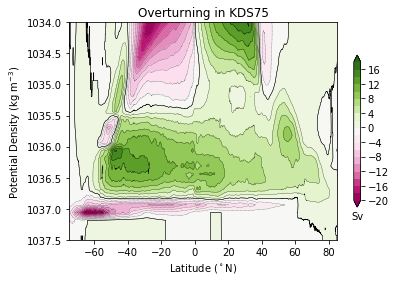

In [33]:
def plot_psi(psi_avg, expt, clev=np.arange(-20,20,2)):

    plt.contourf(psi_avg.grid_yu_ocean, 
                 psi_avg.potrho, 
                 psi_avg, 
                 cmap=plt.cm.PiYG,levels=clev,extend='both')
    cb=plt.colorbar(orientation='vertical', shrink = 0.7)
    cb.ax.set_xlabel('Sv')
    plt.contour(psi_avg.grid_yu_ocean, 
                psi_avg.potrho, 
                psi_avg, levels=clev, colors='k', linewidths=0.25)
    plt.contour(psi_avg.grid_yu_ocean,
                psi_avg.potrho, psi_avg,
                levels=[0.0,], colors='k', linewidths=0.5)
    plt.gca().invert_yaxis()
    
    plt.ylim((1037.5,1034))
    plt.ylabel('Potential Density (kg m$^{-3}$)')
    plt.xlabel('Latitude ($^\circ$N)')
    plt.xlim([-75,85])
    plt.title('Overturning in %s' % expt)

plot_psi(psi_avg, expt)

# Eddy Kinetic Energy
Plan here is to add:
* maps of vertically summed EKE (is this even feasible for this dataset)
* timeseries of globally averaged EKE

We can only do this for portions of simulations which have 5-day average velocities saved, which means directories with `ocean__*.nc` files.


In [7]:
# get a list of simulations with 5-day average velocities (ocean__*.nc files)
expt = 'KDS75'
ExpDir = os.path.join(DataDir, expt)
FileList = sorted(glob(os.path.join(ExpDir, 'output*/ocean__*.nc')))

In [8]:
print(len(FileList))

720


In [25]:
def calc_eke(FileList, box_index, cache=False):
    yi, xi = box_index
    
    eke_filename = 'eke_{}_{}.nc'.format(*box_index)
    if cache and os.path.exists(eke_filename):
        dsx = xr.open_dataset(eke_filename, decode_times=False)
        return dsx
    
    box = {'yu_ocean': slice(300*yi, 300*(yi+1)),
           'xu_ocean': slice(400*xi, 400*(xi+1))}
       
    datasets = []
    for fn in FileList:
        ds = xr.open_dataset(fn, 
                chunks={'time':1, 'st_ocean':7, 
                        'yu_ocean':300, 'xu_ocean': 400}, 
                            decode_times=False)\
               .isel(**box)
        datasets.append(ds)

    u = xr.concat([ds.u for ds in datasets], dim='time', coords='all')
    u_avg = u.mean('time')
    v = xr.concat([ds.v for ds in datasets], dim='time', coords='all')
    v_avg = v.mean('time')

    MKE = 0.5 * (u_avg**2 + v_avg**2)
    MKE = MKE.sum(dim='st_ocean')
    MKE = MKE.to_dataset(name='MKE')
    
    u_ = xr.concat([ds.u - u_avg for ds in datasets], 
                   dim='time', coords='all')
    v_ = xr.concat([ds.v - v_avg for ds in datasets], 
                   dim='time', coords='all')

    EKE = 0.5 * (u_**2 + v_**2)

    EKE = EKE.sum(dim='st_ocean')
    EKE = EKE.to_dataset(name='EKE')

    dsx = xr.merge([MKE, EKE])
    
    if cache:
        dsx.load()
        
        # cache results
        dsx.to_netcdf(eke_filename)
        
    return dsx
    

In [26]:
from itertools import product

# ceil(x/y) = (x+y+1)//y
yi = range(2700//(300)) 
xi = range(3600//(400))

box_indexes = list(product(*[yi, xi]))

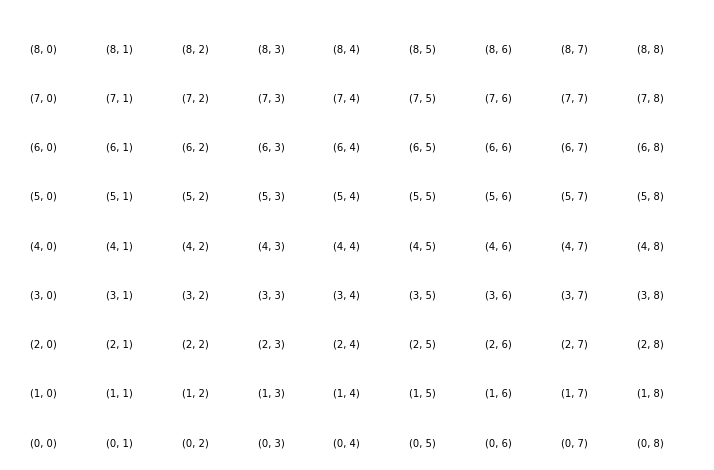

In [27]:
plt.figure(figsize=(12,8))
for box_index in tqdm_notebook(box_indexes):

    plt.subplot(9, 9, box_index[1] + 9*(8-box_index[0])+1 )
    plt.axis('off')

    plt.text(0, 0, box_index)

In [22]:
%%time
dsx = calc_eke(FileList[-72:], (0,0), cache=False)

CPU times: user 8.26 s, sys: 80 ms, total: 8.34 s
Wall time: 15.1 s


In [23]:
dsx.MKE

<xarray.DataArray 'MKE' (yu_ocean: 900, xu_ocean: 1200)>
dask.array<sum-aggregate, shape=(900, 1200), dtype=float64, chunksize=(300, 400)>
Coordinates:
  * xu_ocean  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 -279.5 -279.4 ...
  * yu_ocean  (yu_ocean) float64 -81.09 -81.05 -81.0 -80.96 -80.92 -80.88 ...

In [17]:
%%time
dsx.load()

CPU times: user 2.24 s, sys: 92 ms, total: 2.33 s
Wall time: 15.9 s


<xarray.Dataset>
Dimensions:   (time: 72, xu_ocean: 400, yu_ocean: 300)
Coordinates:
  * xu_ocean  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 -279.5 -279.4 ...
  * yu_ocean  (yu_ocean) float64 -81.09 -81.05 -81.0 -80.96 -80.92 -80.88 ...
  * time      (time) float64 3.577e+04 3.578e+04 3.578e+04 3.579e+04 ...
    geolon_c  (time, yu_ocean, xu_ocean) float64 nan nan nan nan nan nan nan ...
    geolat_c  (time, yu_ocean, xu_ocean) float64 nan nan nan nan nan nan nan ...
Data variables:
    MKE       (yu_ocean, xu_ocean) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    EKE       (time, yu_ocean, xu_ocean) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...

/mnt/miniconda3/envs/cosima/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/mnt/miniconda3/envs/cosima/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/mnt/miniconda3/envs/cosima/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/mnt/miniconda3/envs/cosima/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3644: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  xx = x[x.shape[0]/2,:]
/mnt/miniconda3/envs/cosima/lib/python3.6/site-packages/mpl_toolkits/basema

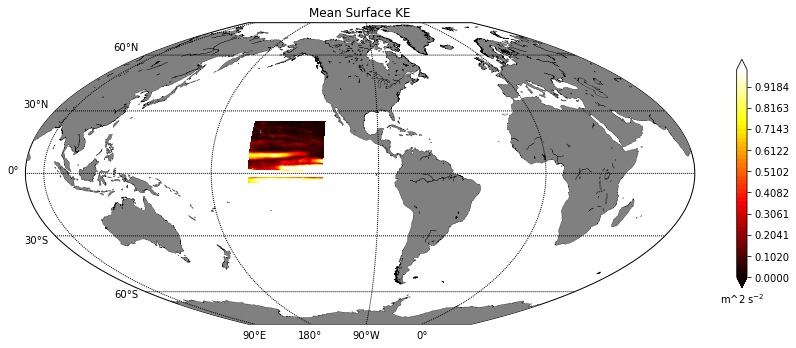

In [41]:
# Plot in basemap 

plt.figure(figsize=(15,6))
lev = np.linspace(0,1.0,50)
map = Basemap(projection='mbtfpq',lon_0 = -100,resolution='l')
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
map.drawparallels(np.arange(-60.,61.,30.),
                  labels=[True,False,False,False])
map.drawmeridians(np.arange(-180.,181.,90.),
                  labels=[False,False,False,True])

x=dsx.xu_ocean[:]
y=dsx.yu_ocean[:]
lon, lat = np.meshgrid(x, y)

X, Y = map(lon,lat) 

map.contourf(X, Y, dsx.MKE,
             cmap=plt.cm.hot,
             levels=lev,extend='both')

cb = plt.colorbar(orientation='vertical',shrink = 0.7)

cb.ax.set_xlabel('m^2 s$^{-2}$')
plt.title('Mean Surface KE')

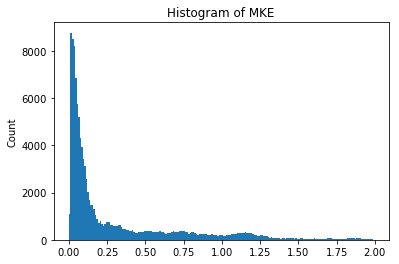

In [42]:
hist = dsx.MKE.plot.hist(bins=np.arange(0,2,0.01))

/mnt/miniconda3/envs/cosima/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/mnt/miniconda3/envs/cosima/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()


/mnt/miniconda3/envs/cosima/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/mnt/miniconda3/envs/cosima/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3644: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  xx = x[x.shape[0]/2,:]
/mnt/miniconda3/envs/cosima/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/mnt/miniconda3/envs/cosima/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/mnt/miniconda3/envs/cosima/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3644: VisibleDeprecationWa

AttributeError: 'str' object has no attribute '__array_priority__'

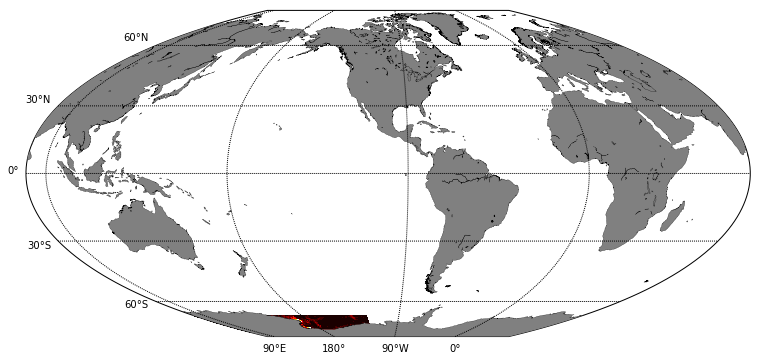

In [43]:
# Plot in basemap 

plt.figure(figsize=(15,6))
lev = np.arange(0, 1.0, 0.05)
map = Basemap(projection='mbtfpq',
              lon_0 = -100, resolution='l')
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
map.drawparallels(np.arange(-60.,61.,30.),
                  labels=[True,False,False,False])
map.drawmeridians(np.arange(-180.,181.,90.),
                  labels=[False,False,False,True])

for box_index in tqdm_notebook(box_indexes):
    #print(box_index)
    dsx = calc_eke(FileList[-72:], box_index, cache=True)
    
    x=dsx.xu_ocean[:]
    y=dsx.yu_ocean[:]
    lon, lat = np.meshgrid(x, y)
    
    X, Y = map(lon,lat) 
    
    map.contourf(X, Y, dsx.MKE,
                 cmap=plt.cm.hot,
                 levels=lev,extend='both')

cb = plt.colorbar(orientation='vertical',shrink = 0.7)

cb.ax.set_xlabel('m^2 s$^{-2}$')
plt.title('Mean KE')

In [ ]:
client.restart()


In [28]:
datasets = []
for box_index in tqdm_notebook(box_indexes):
    dsx = calc_eke(FileList[-72:], box_index, cache=True)
    #dsx = dsx.EKE.mean('xu_ocean').mean('yu_ocean')
    #datasets.append(dsx)

distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/mnt/miniconda3/envs/cosima/lib/python3.6/site-packages/distributed/utils.py", line 212, in f
    result[0] = yield make_coro()
  File "/mnt/miniconda3/envs/cosima/lib/python3.6/site-packages/tornado/gen.py", line 1015, in run
    value = future.result()
  File "/mnt/miniconda3/envs/cosima/lib/python3.6/site-packages/tornado/concurrent.py", line 237, in result
    raise_exc_info(self._exc_info)
  File "<string>", line 3, in raise_exc_info
  File "/mnt/miniconda3/envs/cosima/lib/python3.6/site-packages/tornado/gen.py", line 1021, in run
    yielded = self.gen.throw(*exc_info)
  File "/mnt/miniconda3/envs/cosima/lib/python3.6/site-packages/distributed/client.py", line 1551, in _get
    result = yield self._gather(packed)
  File "/mnt/miniconda3/envs/cosima/lib/python3.6/site-packages/tornado/gen.py", line 1015, in run
    value = future.result()
  File "/mnt/miniconda3/envs/cosima/lib/python3.6/site-packages/tornado/

MemoryError: 

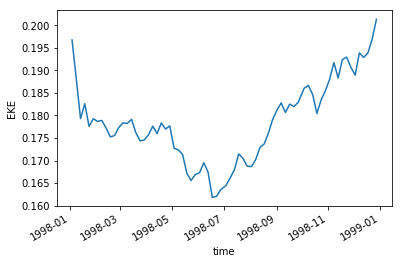

In [69]:
mean_EKE = xr.concat(datasets, dim='boxid').mean('boxid')

dsx = mean_EKE.to_dataset(name='EKE')
dsx.time.attrs["units"] = 'days since 1900-01-01'
dsx = xr.decode_cf(dsx, decode_times=True)

dsx.EKE.plot()